In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

from src.utils import load_all_csv_in_dir

In [2]:
data_dir = os.path.join("..", "PythonAnygrad", "save")
data = load_all_csv_in_dir(data_dir)

In [3]:
data

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
0,"Baseline (round robin, m=50)",0,0,Target 1,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,"Baseline (round robin, m=50)",0,0,Target 2,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,"Baseline (round robin, m=50)",0,0,Target 3,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,"Baseline (round robin, m=50)",0,1,Target 1,-1094.199251,50,50,50,5.286130,0.423022,-0.423021,0.008460,NaN,NaN,NaN
4,"Baseline (round robin, m=50)",0,1,Target 2,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Anygrad (full),4,32,Target 2,-898.059501,200,1900,5500,181.948386,9.626034,4.809384,0.005065,0.076038,-0.000027,2.518043
503,Anygrad (full),4,32,Target 3,-899.336792,200,1700,5300,176.115801,8.616302,4.747473,0.005064,0.198057,-0.000088,6.571262
504,Anygrad (full),4,33,Target 1,-912.033040,200,1900,5100,170.233630,9.612468,4.843353,0.005058,0.140973,-0.000040,4.679769
505,Anygrad (full),4,33,Target 2,-898.059501,200,1900,5500,181.948386,9.626034,4.809384,0.005065,0.076038,-0.000027,2.518043


In [4]:
alpha = 0.5

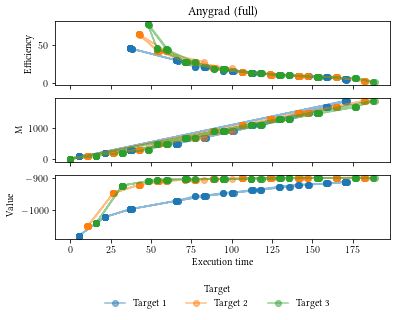

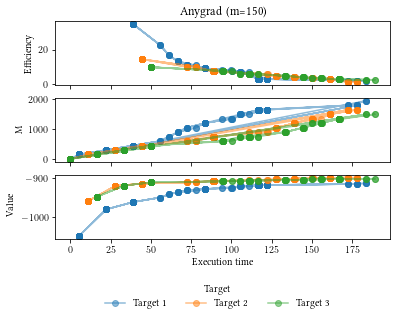

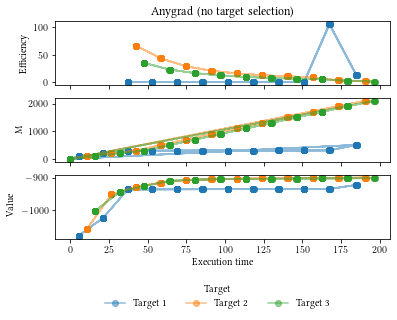

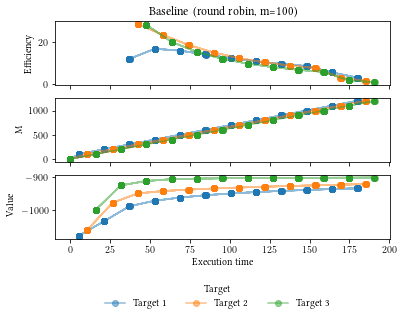

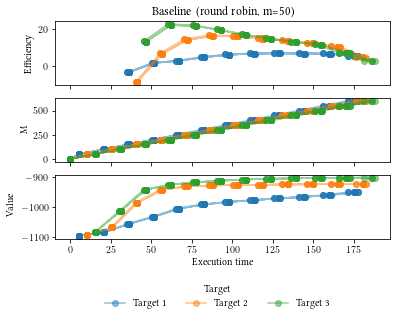

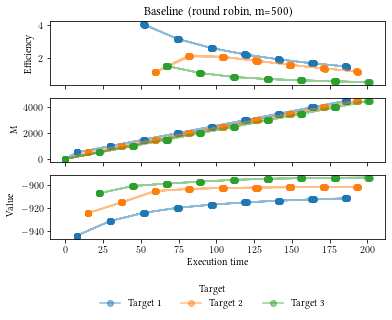

In [5]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    for target in targets:
        target_data = this_data[this_data["target"] == target]
        axes[0].plot(target_data["total_time"], target_data["efficiency"], label=target, alpha=alpha, marker="o")
        axes[1].plot(target_data["total_time"], target_data["M"], label=target, alpha=alpha, marker="o")
        axes[2].plot(target_data["total_time"], target_data["value"], label=target, alpha=alpha, marker="o")
        axes[0].set_title(strategy)
    axes[0].set_ylabel("Efficiency")
    axes[1].set_ylabel("M")
    axes[2].set_ylabel("Value")
    axes[-1].set_xlabel("Execution time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

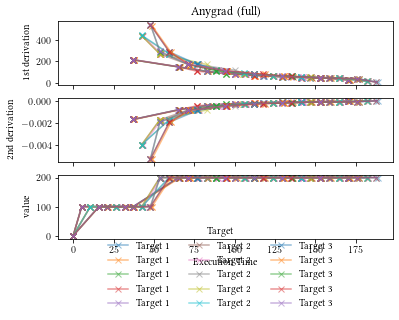

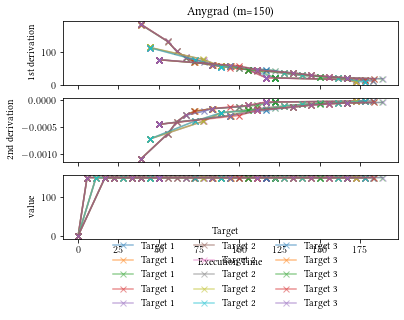

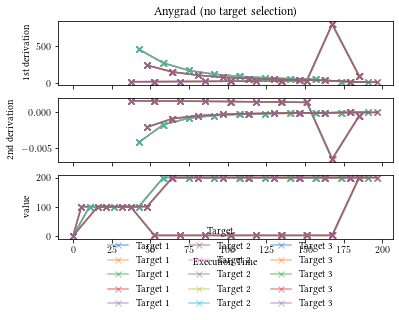

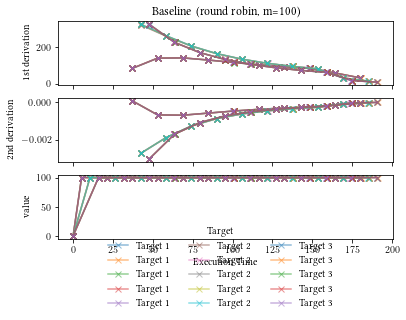

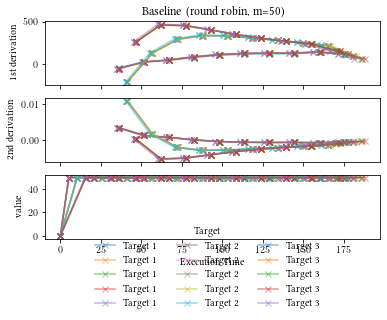

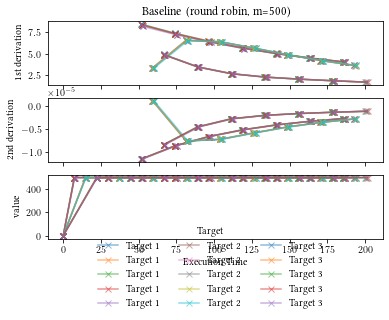

In [71]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    reps = np.unique(this_data["rep"])
    for target in targets:
        for rep in reps:
            target_data = this_data[np.logical_and(this_data["target"] == target, this_data["rep"] == rep)]
            axes[0].plot(target_data["total_time"], target_data["derivation_1st"] / target_data["t1"],
                         label=target, alpha=alpha, marker="x")
            axes[1].plot(target_data["total_time"], target_data["derivation_2nd"],
                         label=target, alpha=alpha, marker="x")
            axes[2].plot(target_data["total_time"], target_data["m"],
                         label=target, alpha=alpha, marker="x")
            axes[0].set_title(strategy)
    axes[0].set_ylabel("1st derivation")
    axes[1].set_ylabel("2nd derivation")
    axes[2].set_ylabel("value")
    axes[-1].set_xlabel("Execution Time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [62]:
def get_auc(x, y, offset: float):
    x = np.array(x)
    y = np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = np.nanmin(y) - y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]) + offset*(x[i-1]-x[0]))
            for i in range(1, len(y), 1)]
    return x[1:], area

def group_df(df: pd.DataFrame):
    df = df.sort_values(by="total_iterations").groupby(by=["strategy", "target"])
    return df

def prepend_first_row(df: pd.DataFrame):
    current_data = pd.concat([df.iloc[0], df], ignore_index=True)
    current_data["total_time"].iloc[0] = 0.0
    current_data["total_iterations"].iloc[0] = 0.0
    return current_data

In [67]:
strategies = np.unique(data["strategy"])
df_per_strategy = [data.sort_values(by="total_time")
                       .groupby(by=["strategy"])
                       .get_group(strategy) for strategy in strategies]
df_per_strategy = [df.rolling(window=5).mean() for df in df_per_strategy]

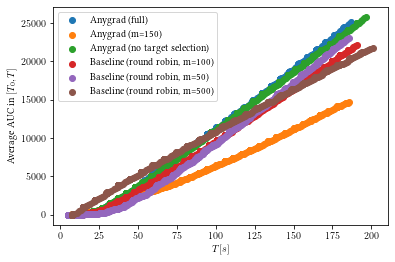

In [68]:
min_losses = [np.nanmin(df["value"]) for df in df_per_strategy]
offsets = np.array(min_losses) - np.nanmin(min_losses)
offset = np.nanmax(min_losses)
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = get_auc(x, y, offset=offsets[i])
    plt.scatter(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Average AUC in $[T_0, T]$")
plt.show()

/usr/local/Caskroom/miniconda/base/envs/anygrad/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


TypeError: get_auc() missing 1 required positional argument: 'offset'

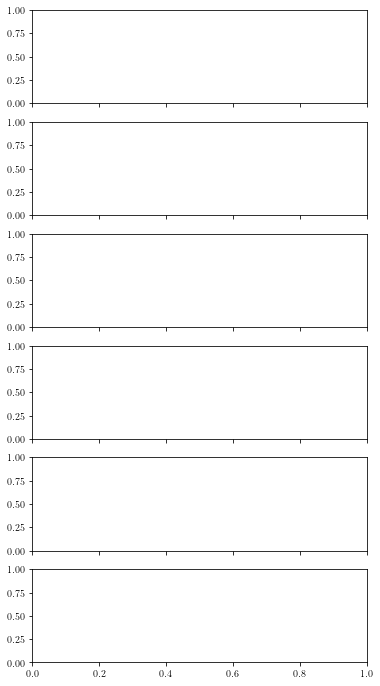

In [69]:
grouped_df = group_df(data)
indices = grouped_df.indices
strategies = np.unique([index[0] for index in indices.keys()])
targets = np.unique([index[1] for index in indices.keys()])

fig, axes = plt.subplots(nrows=len(strategies), ncols=1, sharey="all", sharex="all", figsize=(6,12))
for i, strat in enumerate(strategies):
    for target in targets:
        current_data = grouped_df.get_group((strat, target))
        current_data = prepend_first_row(current_data)
        x = current_data["total_time"]
        x, auc = get_auc(x,
                         y=current_data["value"])
        axes[i].plot(x,
                     auc,
                     label=target)
    axes[i].set_title(strat)
    axes[i].set_ylabel("Value")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
axes[-1].set_xlabel("Execution time")
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.05, 1, 1),
                    frameon=False, ncol=3, title="Target")
plt.tight_layout()
plt.show()

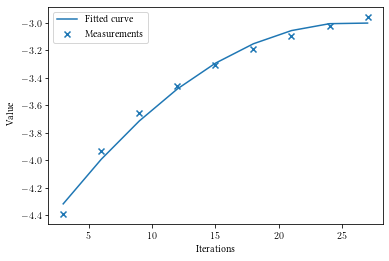

In [11]:
y = [-4.39331878, -3.93170969, -3.65555667, -3.45794343, -3.30895812, -3.1925142,
     -3.09831504, -3.02023389, -2.95436115]
x = [3.,  6.,  9., 12., 15., 18., 21., 24., 27.]
coefficients = [-2.54097250e-03, 1.31063455e-01, -4.68765366e+00]

def q_function(x):
    return coefficients[0] * x*x + coefficients[1] * x + coefficients[2]

plt.scatter(x, y, marker="x", label="Measurements")
plt.plot(x, q_function(np.array(x)), label="Fitted curve")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.legend()
plt.show()